# Pressure Test

## Status

#### Testing for within 1 smoothing length
* Tested two particles, and they move apart, regardless of their starting position
* Tested 4 particles in the following configurations, and they move apart
    * 3 colinear, and 1 off axis
    * Square
* Tested 5 paricles, in the following configurations, and they move apart
    * Square, with one extra particle in the middle
    * Square, with one particle slightly off center
        * The particle stays put for a while, but then accelerates suspiciously quickly
* dt is unreasonably large right now

#### Testing for within 2 smoothing lengths

#### Visualizing the acceleration
* Haven't done it yet, but color the particles with their acc

## Next step
* Test more particles

#### Did that
* Results: Do not take a dot product to get gradP

## Notes
* W1 inside of gradW is returning a 3D array. It should be returning a 2D array.
* Within distVect, there is one entry in each row which is the distance between the particle and itself (ie: 0)
* Some distVect returns a boolean, sometimes a 1 or a 0

### Imports

In [86]:
%pylab inline

from __future__ import division

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb

Populating the interactive namespace from numpy and matplotlib


### Constants

In [87]:
dt = 1e6
stepN = 6000

### Initialize position, velocity, mass, pressure, density, and time

In [88]:
### --- Distribution Case 1 --- ###
xyDistribution = np.array(([1.0e8, 1.0e8], 
                           [-1.0e8, -1.0e8],
                           [-1.0e8, 1.0e8]))
nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
# nParticles = 50
# xyDistribution = np.random.normal(0,100, size=(nParticles, 2))

velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))


timeArray = np.arange(0, stepN*dt, dt)

[]

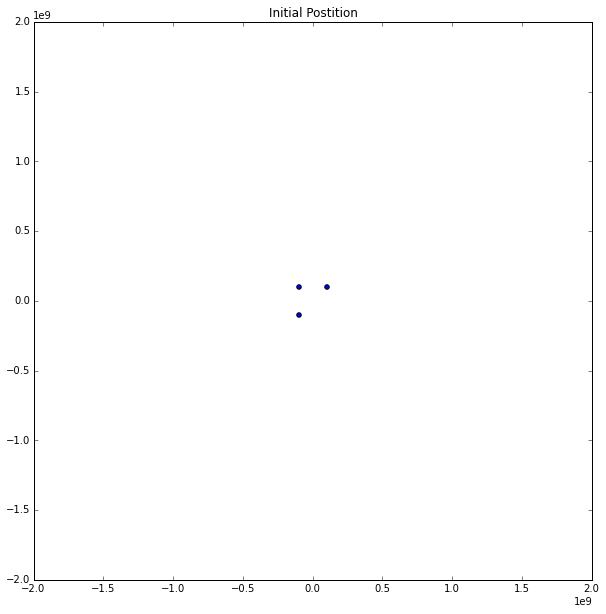

In [89]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2e9, 2e9)
plt.ylim(-2e9, 2e9)
plt.title("Initial Postition")
plt.plot()

In [90]:
print "True distance:\n", cdist(xyDistribution, xyDistribution)
Xloc = np.array(xyDistribution[:,0])

print Xloc


True distance:
[[  0.00000000e+00   2.82842712e+08   2.00000000e+08]
 [  2.82842712e+08   0.00000000e+00   2.00000000e+08]
 [  2.00000000e+08   2.00000000e+08   0.00000000e+00]]
[  1.00000000e+08  -1.00000000e+08  -1.00000000e+08]


### Define smoothing gradient

In [91]:
def gradW(xyDistribution, h= 3e9, verbose=False):
    '''
    TESTS
    h works fine
    
    Are we doing this in cartesian or polar?
    h = ~3e9 looks like a good range
    Finding W for all pairs (i,j), instead of just j. 
    I'm flattening W at the end of the function. I might be meant to flatten W
        by flattening the |r-rj| by taking their sum
    Should I be inputting abs(X) or just X? What is X relative to?
    Might need to do final summation wrt axis 2, not axis1
    '''
    distVect = np.zeros((len(xyDistribution), len(xyDistribution)))
    thetaVect = np.zeros_like(distVect)
    X = np.zeros_like(distVect)
    Y = np.zeros_like(distVect)
                  
    # Find distance between each j and the other points
    for i in range(len(xyDistribution)):
        particle_i = xyDistribution[i]
        
        # Sloppy right now. Can save save computing power later.
        dist = np.sqrt((particle_i[0] - xyDistribution[:,0])**2 + (particle_i[1] - xyDistribution[:,1])**2)
        theta = np.arctan((particle_i[1] - xyDistribution[:,1])/particle_i[0] - xyDistribution[:,0])
        
        ### --- OPERATING ON AN ENTIRE ROW --- ###
        deltaX = particle_i[0] - xyDistribution[:,0]
        deltaY = particle_i[1] - xyDistribution[:,1]
        # Store radial distances in a matrix
        distVect[:,i] = dist
        X[:,i] = deltaX
        Y[:,i] = deltaY
#        thetaVect[:,i] = np.rad2deg(theta)
    
#    print distVect
#    print thetaVect
    
    # r < 1
    # Vector containing 1's and 0's where the below inequality is satisfied
    distVect1 = distVect < h
    distVect1 = distVect1.astype(int)
    if verbose:
        print "Percent of molecules within 1 smoothing length:", \
            np.count_nonzero(distVect1) / (len(xyDistribution)**2)
            
#    print distVect1
            
    # Matrix containing radii, where only nonzero values are radii < h
    R1 = distVect1 * distVect
    X1 = distVect1 * X
    Y1 = distVect1 * Y
#     print R1
#     print X1
#     print Y1

    
### --- EVERYTHING ABOVE THIS LINE WORKS ---###

    # X and Y components of the smoothing kernel
    W1 = np.array(
         [distVect1 * 3/ (2*np.pi * h**4) * ( -2*X1 + 3*X1*np.sqrt(R1)/h), \
          distVect1 * 3/ (2*np.pi * h**4) * ( -2*Y1 + 3*Y1*np.sqrt(R1)/h)]
                  )
    
#     print W1

#     # r > 2h
#     distVect2 = distVect > 2 * h
#     distVect2 = distVect2.astype(int)
#     if verbose:
#         print "Percent of molecules which do not affect the particle:", \
#             np.count_nonzero(distVect2) / (len(xyDistribution)**2)
    
#     # h < r < 2h
#     distVect12 = np.logical_not(np.logical_or(distVect1, distVect2))
#     if verbose:
#         print "Percent of molecules within 2 smoothing lengths:", \
#                 np.count_nonzero(distVect12) / (len(xyDistribution)**2)
            
#     R12 = distVect12 * distVect 
#     X12 = distVect12 * XVect
#     Y12 = distVect12 * YVect
#     W12 = np.array(
#          [distVect1 / (4*np.pi * h**6) * ( -2*X1 / np.sqrt(R1)), \
#           distVect1 / (4*np.pi * h**6) * ( -2*Y1 / np.sqrt(R1))]
#                     )
#     W12 = np.nan_to_num(W12)
    
#     W = W1 + W12
#     W = np.nan_to_num(W)
#     W = np.sum(W, axis=1)

#     print np.min(W12)
    
#     return W
    W1 = np.sum(W1, axis=1).T
    return W1

### Redefining gradW in terms of Gaussian

In [92]:
# def gradW(h= 2e8, verbose=False):
#     distVect = np.zeros((len(xyDistribution), len(xyDistribution)))
#     X = np.zeros_like(distVect)
#     Y = np.zeros_like(distVect)
                  
#     # Find distance between each j and the other points
#     for i in range(len(xyDistribution)):
#         particle_i = xyDistribution[i]
        
#         # Sloppy right now. Can save save computing power later.
#         dist = np.sqrt((particle_i[0] - xyDistribution[:,0])**2 + (particle_i[1] - xyDistribution[:,1])**2)
        
#         ### --- OPERATING ON AN ENTIRE ROW --- ###
#         deltaX = particle_i[0] - xyDistribution[:,0]
#         deltaY = particle_i[1] - xyDistribution[:,1]
#         # Store radial distances in a matrix
#         distVect[:,i] = dist
#         X[:,i] = deltaX
#         Y[:,i] = deltaY
        
#     dWX = -2*X/(h**4 * np.pi) * np.exp(-distVect**2/h**2)
#     dWY = -2*Y/(h**4 * np.pi) * np.exp(-distVect**2/h**2)
#     W = np.array((dWX, dWY))
#     W = np.sum(W, axis=1)
#     return W

# z = gradW()
# print z

In [93]:
def gradP():
    gradPX = mDistribution*pressureDistribution/rhoDistribution \
        * gradW(xyDistribution)[:,0]
        
    gradPY = mDistribution*pressureDistribution/rhoDistribution \
        * gradW(xyDistribution)[:,1]
    return np.array((gradPX, gradPY)).T

In [94]:
# print gradW(xyDistribution)
print gradP()

[[ -1.25751080e+11  -6.28754982e+10]
 [  6.28754982e+10   1.25751080e+11]
 [  6.28755823e+10  -6.28755823e+10]]


### Calculate force

In [95]:
def RK1(f, dt, position, stepN):
    
    t = 0
    for i in range(stepN):
        t+=dt
        ### --- I might be dividing along the wrong axis --- ###
        ParticleVelocityHistory[:,:,i] = -gradP()/rhoDistribution[:,np.newaxis] * dt
        position += dt*ParticleVelocityHistory[:,:,i]
        ParticlePositionHistory[:,:,i] = position
    #print(position)
    return position

In [96]:
numbaRK = nb.autojit(RK1)
numbaPressure = nb.autojit(gradP)

xyDistribution = RK1(gradP, dt, xyDistribution, stepN)

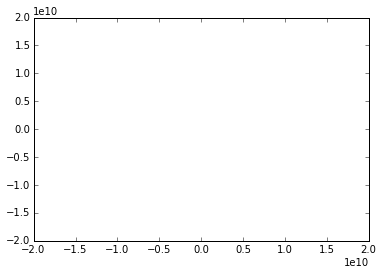

In [97]:
slider = FloatSlider(description='Time', min=0, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[:,0,time-1]
    y = ParticlePositionHistory[:,1,time-1]
    fig = plt.figure()
    plt.scatter(x, y)
    plt.xlim(-2e10, 2e10)
    plt.ylim(-2e10, 2e10)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

In [98]:
print gradP()[:,0]/rhoDistribution

[ 0.  0.  0.]


In [99]:
print gradP()/rhoDistribution[:,np.newaxis]
print gradP().shape
print rhoDistribution.shape

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
(3L, 2L)
(3L,)
